In [12]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
from scipy.stats import zscore
import optuna
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import matplotlib.pyplot as plt

c:\Users\Administrator\Desktop\FinetuningOptuna\venv\lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


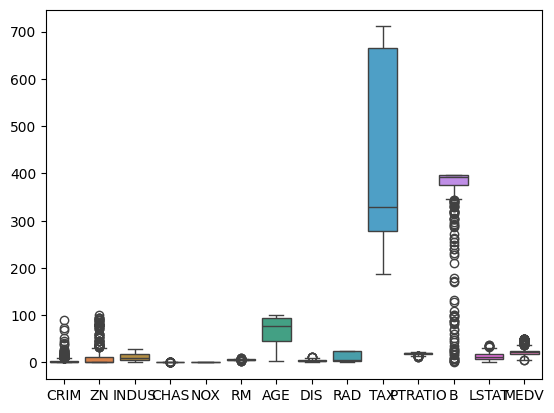

In [2]:
data = pd.read_csv("C:/Users/Administrator/Desktop/FinetuningOptuna/boston.csv")
sns.boxplot(data)
out = IForest(contamination=0.1)
out_pred = out.fit_predict(data)
std_data = data[out_pred == 1]

<Axes: >

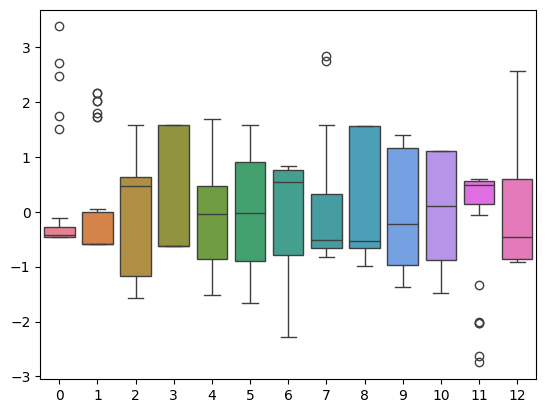

In [3]:
X = std_data.drop("MEDV", axis = 1)
y = std_data["MEDV"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
sns.boxplot(X_train_scaled)


In [4]:
model = MLPRegressor()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print(r2_score(y_test, y_pred))
mean_absolute_error(y_test, y_pred)

-0.5111241852032868


12.570121768214266

In [5]:
def objective(trial):
    n_layers=trial.suggest_int('n_layers',1,5)
    layers=[trial.suggest_int(f'n_units_l{i}',16,128) for i in range(n_layers)]
    activation=trial.suggest_categorical('activation',['relu','identity','logistic','tanh'])
    solver=trial.suggest_categorical('solver',['lbfgs','adam','sgd'])
    alpha=trial.suggest_float('alpha',1e-5,1.0,log=True)
    tol=trial.suggest_float('tol',1e-6,1e-3,log=True)
    mlp_kwargs=dict(hidden_layer_sizes=tuple(layers),activation=activation,solver=solver,alpha=alpha,tol=tol,max_iter=1000)
    if solver=='lbfgs':
        mlp_kwargs['max_fun']=trial.suggest_int('max_fun',15000,100000)
    elif solver=='adam':
        mlp_kwargs['learning_rate_init']=trial.suggest_float('learning_rate_init',1e-4,5e-2,log=True)
        mlp_kwargs['beta_1']=trial.suggest_float('beta_1',0.85,0.99)
        mlp_kwargs['beta_2']=trial.suggest_float('beta_2',0.9,0.9999)
        mlp_kwargs['epsilon']=trial.suggest_float('epsilon',1e-9,1e-6,log=True)
        mlp_kwargs['early_stopping']=True
        mlp_kwargs['validation_fraction']=trial.suggest_float('validation_fraction',0.05,0.25)
        mlp_kwargs['n_iter_no_change']=trial.suggest_int('n_iter_no_change',10,40)
        mlp_kwargs['batch_size']=trial.suggest_categorical('batch_size',[32,64,128,256,512])
        mlp_kwargs['shuffle']=trial.suggest_categorical('shuffle',[True,False])
    else:
        mlp_kwargs['learning_rate']=trial.suggest_categorical('learning_rate',['constant','invscaling','adaptive'])
        mlp_kwargs['learning_rate_init']=trial.suggest_float('learning_rate_init',1e-4,5e-2,log=True)
        if mlp_kwargs['learning_rate']=='invscaling':
            mlp_kwargs['power_t']=trial.suggest_float('power_t',0.1,0.9)
        mlp_kwargs['momentum']=trial.suggest_float('momentum',0.0,0.99)
        mlp_kwargs['nesterovs_momentum']=trial.suggest_categorical('nesterovs_momentum',[True,False])
        mlp_kwargs['early_stopping']=True
        mlp_kwargs['validation_fraction']=trial.suggest_float('validation_fraction',0.05,0.25)
        mlp_kwargs['n_iter_no_change']=trial.suggest_int('n_iter_no_change',10,40)
        mlp_kwargs['batch_size']=trial.suggest_categorical('batch_size',[32,64,128,256,512])
        mlp_kwargs['shuffle']=trial.suggest_categorical('shuffle',[True,False])
    try:
        model=MLPRegressor(**mlp_kwargs,random_state=369)
        model.fit(X_train_scaled,y_train)
        y_pred=model.predict(X_test_scaled)
        r2=r2_score(y_test,y_pred)
        return r2 if r2>0 else -1.0
    except Exception:
        return -1.0

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_jobs=-1, n_trials=1000)

[I 2025-08-23 23:18:16,554] A new study created in memory with name: no-name-1356a45c-7453-4a81-bd9a-af20adb88622
c:\Users\Administrator\Desktop\FinetuningOptuna\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Administrator\Desktop\FinetuningOptuna\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Administrator\Desktop\FinetuningOptuna\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Administrator\Desktop\FinetuningOptuna\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or la

R2: 0.9341417251399041
MAE: 2.351960881840034


Text(0, 0.5, 'Y_pred')

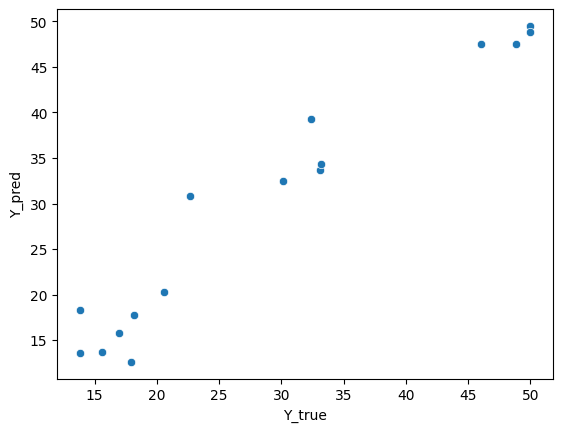

In [13]:
bp = study.best_params
if 'n_layers' in bp:
    hidden = tuple(bp[f'n_units_l{i}'] for i in range(bp['n_layers']))
else:
    unit_keys = sorted([k for k in bp.keys() if k.startswith('n_units_l')], key=lambda x: int(x.split('l')[1]))
    hidden = tuple(bp[k] for k in unit_keys)
solver = bp.get('solver','adam')
mlp_kwargs = {
    'hidden_layer_sizes': hidden,
    'activation': bp.get('activation','relu'),
    'solver': solver,
    'alpha': bp.get('alpha',1e-4),
    'tol': bp.get('tol',1e-4),
    'max_iter': 2000
}

if solver == 'lbfgs':
    if 'max_fun' in bp: mlp_kwargs['max_fun'] = bp['max_fun']
else:
    if 'early_stopping' in bp: mlp_kwargs['early_stopping'] = bp['early_stopping']
    if 'validation_fraction' in bp: mlp_kwargs['validation_fraction'] = bp['validation_fraction']
    if 'n_iter_no_change' in bp: mlp_kwargs['n_iter_no_change'] = bp['n_iter_no_change']
    if 'learning_rate_init' in bp: mlp_kwargs['learning_rate_init'] = bp['learning_rate_init']
    if 'batch_size' in bp: mlp_kwargs['batch_size'] = bp['batch_size']
    if 'shuffle' in bp: mlp_kwargs['shuffle'] = bp['shuffle']
    if solver == 'adam':
        if 'beta_1' in bp: mlp_kwargs['beta_1'] = bp['beta_1']
        if 'beta_2' in bp: mlp_kwargs['beta_2'] = bp['beta_2']
        if 'epsilon' in bp: mlp_kwargs['epsilon'] = bp['epsilon']
    elif solver == 'sgd':
        if 'learning_rate' in bp: mlp_kwargs['learning_rate'] = bp['learning_rate']
        if 'learning_rate_init' in bp: mlp_kwargs['learning_rate_init'] = bp['learning_rate_init']
        if bp.get('learning_rate') == 'invscaling' and 'power_t' in bp: mlp_kwargs['power_t'] = bp['power_t']
        if 'momentum' in bp: mlp_kwargs['momentum'] = bp['momentum']
        if 'nesterovs_momentum' in bp: mlp_kwargs['nesterovs_momentum'] = bp['nesterovs_momentum']

model = MLPRegressor(**mlp_kwargs, random_state=369)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("R2:", r2)
print("MAE:", mae)

sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Y_true")
plt.ylabel("Y_pred")
